# 🧩 Evaluation Results Visualization - LLM Syntax Error Checker
This notebook visualizes the accuracy metrics and shows example failures.
Run this after generating `results.json` using `evaluate.py`.

In [1]:
# Safe load of results.json (runs evaluate.py if missing)
import os, json, subprocess, sys
from pathlib import Path

RESULTS_PATH = Path("results.json")
DATASET_PATH = Path("dataset/errors_dataset.csv")

if not RESULTS_PATH.exists():
    print("results.json not found — running evaluation to create it...")
    # Run evaluate.py to create results.json
    cmd = [sys.executable, "evaluate.py", "--dataset", str(DATASET_PATH), "--out", str(RESULTS_PATH)]
    proc = subprocess.run(cmd, capture_output=True, text=True)
    print(proc.stdout)
    if proc.returncode != 0:
        print("evaluate.py failed. stderr:\n", proc.stderr)
        raise RuntimeError("Could not generate results.json; fix evaluate.py errors first.")

with open(RESULTS_PATH, "r", encoding="utf-8") as f:
    results = json.load(f)

# Quick print
import pprint
pprint.pprint(results)


{'overall_recall': 1.0,
 'per_type': {'IndentationError': {'false_positive': 0,
                                   'precision': 1.0,
                                   'recall': 1.0,
                                   'total': 105,
                                   'true_positive': 105},
              'MissingColon': {'false_positive': 0,
                               'precision': 1.0,
                               'recall': 1.0,
                               'total': 105,
                               'true_positive': 105},
              'UnclosedQuotes': {'false_positive': 117,
                                 'precision': 0.473,
                                 'recall': 1.0,
                                 'total': 105,
                                 'true_positive': 105},
              'UnmatchedBracket': {'false_positive': 0,
                                   'precision': 1.0,
                                   'recall': 1.0,
                                   'total': 1

In [2]:
# Build DataFrame from results per-type metrics
import pandas as pd

metrics = []
for k, v in results.get("per_type", {}).items():
    row = {"Error Type": k}
    row.update(v)
    metrics.append(row)

df = pd.DataFrame(metrics)
if df.empty:
    print("No per_type metrics found in results.json")
else:
    df = df.sort_values("recall", ascending=False).reset_index(drop=True)
df


,Error Type,total,true_positive,false_positive,recall,precision
0,MissingColon,105,105,0,1.0,1.000
1,UnmatchedBracket,105,105,0,1.0,1.000
2,IndentationError,105,105,0,1.0,1.000
3,UnclosedQuotes,105,105,117,1.0,0.473


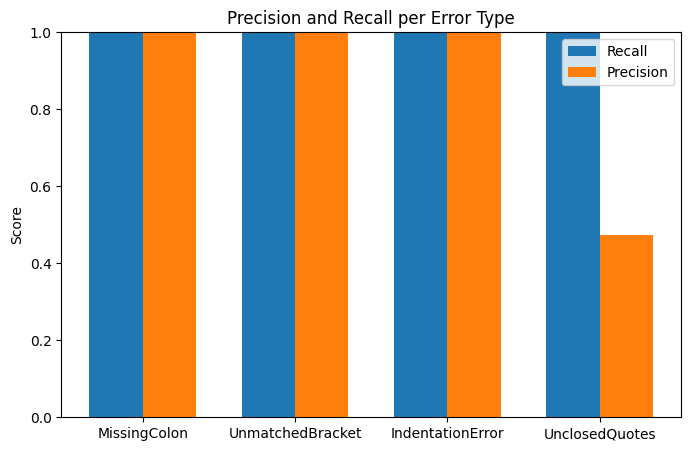

In [3]:
# Plot precision and recall (matplotlib)
import matplotlib.pyplot as plt
import numpy as np

if df.empty:
    print("No metrics to plot.")
else:
    ind = np.arange(len(df))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(ind - width/2, df['recall'], width, label='Recall')
    ax.bar(ind + width/2, df['precision'], width, label='Precision')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1.0)
    ax.set_title('Precision and Recall per Error Type')
    ax.set_xticks(ind)
    ax.set_xticklabels(df['Error Type'])
    ax.legend()
    plt.show()


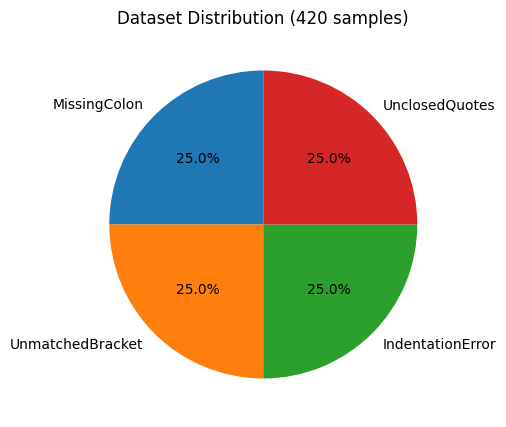

In [4]:
# Dataset distribution
import pandas as pd
import matplotlib.pyplot as plt

if not DATASET_PATH.exists():
    print("Dataset not found at", DATASET_PATH)
else:
    ds = pd.read_csv(DATASET_PATH)
    counts = ds['error_type'].value_counts()
    plt.figure(figsize=(5,5))
    counts.plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(f"Dataset Distribution ({len(ds)} samples)")
    plt.ylabel('')
    plt.show()


In [5]:
# Collect failed examples safely (may be slow if dataset large)
from syntax_checker import detect_all
import pandas as pd

failed = []

try:
    ds  # use ds from previous cell if available
except NameError:
    ds = pd.read_csv(DATASET_PATH)

for idx, row in ds.iterrows():
    code = row['buggy_code']
    expected = row['error_type']
    try:
        detected = [d['type'] for d in detect_all(code)]
    except Exception as e:
        # If detector crashes on a particular snippet, record the crash as a failure
        detected = []
        failed.append({
            'id': row.get('id'),
            'error_type': expected,
            'buggy_code': code,
            'detected': detected,
            'error': f'Detector exception: {e}'
        })
        continue

    if expected not in detected:
        failed.append({
            'id': row.get('id'),
            'error_type': expected,
            'buggy_code': code,
            'detected': detected
        })

failed_df = pd.DataFrame(failed)
print("Missed detections:", len(failed_df))
failed_df.head(20)


Missed detections: 0


""


In [6]:
# Summary stats and save failed cases
print("Total dataset samples:", len(ds))
print("Missed detections:", len(failed_df))
print("Overall recall (from results.json):", results.get('overall_recall'))

if not failed_df.empty:
    failed_df.to_csv("failed_cases.csv", index=False)
    print("Saved failed_cases.csv")
else:
    print("No failed cases to save.")


Total dataset samples: 420
Missed detections: 0
Overall recall (from results.json): 1.0
No failed cases to save.
